In [42]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt



In [43]:
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

In [51]:
orders = pd.read_csv('C:/Sahil Folders/Github Projects/Sahil-Assignments/Churn Modelling/Bayesian Approach/Data/olist_orders_dataset.csv')
items = pd.read_csv('C:/Sahil Folders/Github Projects/Sahil-Assignments/Churn Modelling/Bayesian Approach/Data/olist_order_items_dataset.csv')
cust = pd.read_csv('C:/Sahil Folders/Github Projects/Sahil-Assignments/Churn Modelling/Bayesian Approach/Data/olist_customers_dataset.csv')

### Refine

In [52]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
Name: count, dtype: int64

In [53]:
print(items.columns)
#items.drop_duplicates('order_id',keep='first',inplace=True)


#orders.columns = [['customer_id', 'customer_unique_id', 'customer_zip_code_prefix','customer_city', 'customer_state', 'customer_unique_id_y']]
print(orders.columns)

print(cust.columns)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [54]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


In [55]:
orders.head(n = 4)
#list(orders.columns).find('customer_unique_id_x')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977


In [56]:
transaction_data = pd.merge(orders,items,how = 'inner',on = 'order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

In [57]:
## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


Now that I have my transaction data, I want to convert this into dataframe with the RFM variables that I mentioned in the introduction. The Lifetimes package has a function for converting transaction data into an RFM DataFrame. 

In [58]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.818576
std,0.178936,25.263074,153.656402,29.891892
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,2040.000000


### Final Raw Values

In [59]:
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [60]:
summary['frequency'].value_counts()

frequency
0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: count, dtype: int64

In [61]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

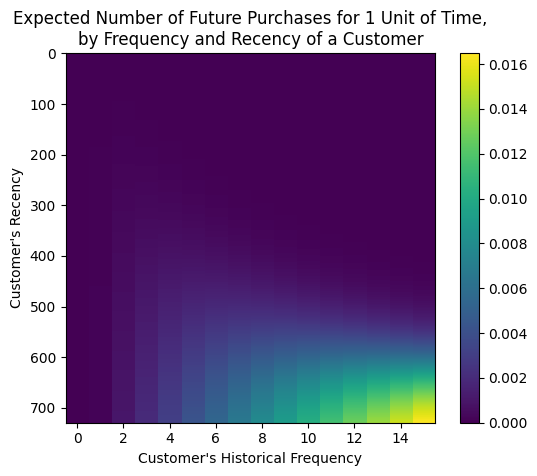

In [62]:
plot_frequency_recency_matrix(bgf); 

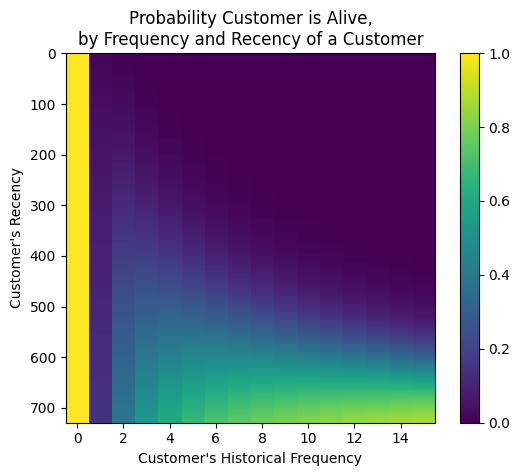

In [63]:
plot_probability_alive_matrix(bgf);

#### 1) Calibration period histogram

C:\Users\sahil\miniconda3\Lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: overflow encountered in scalar divide
  next_purchase_in = random.exponential(scale=1.0 / l)


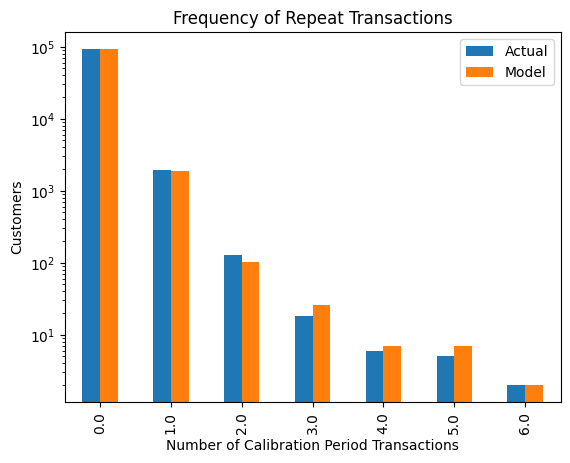

In [64]:
plot_period_transactions(bgf).set_yscale('log');

The model is fairly representative of the real data up until four repeat transactions. There are few customers who make more purchases.

The red line represents the boundary between the calibration period on the left and the holdout period on the right. As you can see, the BG/NBD model does a pretty swell job at predicting cumulative transactions.

This plot shows that the model does a decent job capturing general trends in the data. 

### Modeling churn risk

C:\Users\sahil\AppData\Local\Temp\ipykernel_9104\2120726772.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['prob_alive']);


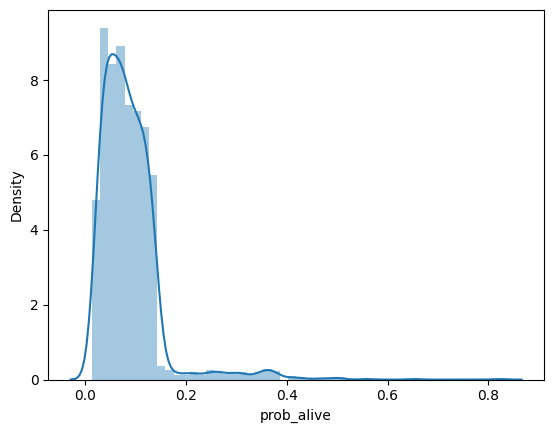

In [66]:
df = summary[summary['frequency']>0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'],df['recency'],df['T'])
sns.distplot(df['prob_alive']);

In [67]:
high_risk_customer = df[(df.prob_alive>=.1) & (df.prob_alive<.3)]
print("high_risk_customer",len(high_risk_customer))
active_customers = df[(df['prob_alive']>=.3)]
print("active_customer",len(active_customers))
churn_customers = df[(df.prob_alive<.1)]
print("churn_customer",len(churn_customers))

high_risk_customer 625
active_customer 50
churn_customer 1410


In [68]:
high_risk_customer = df[(df.prob_alive>0.1) & (df.prob_alive<0.3)]
high_risk_customer.sort_values(by="prob_alive", ascending = False)

,frequency,recency,T,monetary_value,prob_alive
customer_unique_id,,,,,
acea6bd29b8c1e3c6a8b266a8fb4475e,3.0,247.0,369.0,148.193333,0.296514
56c8638e7c058b98aae6d74d2dd6ea23,3.0,281.0,418.0,168.023333,0.294251
7589544c08cc5de364cad85ee73f4b63,2.0,217.0,288.0,74.800000,0.294093
8961b4ca2c5aceb7a78ea72c6e0c840a,2.0,208.0,280.0,253.340000,0.290147
821e75291b1ad362e614c0ea79fc95a6,2.0,90.0,132.0,160.000000,0.287999
...,...,...,...,...,...
b2e9a05d23ea17713b5d7799f2004f8e,1.0,3.0,39.0,30.000000,0.100315
c499023d38f0db1bcf3db96b3c8a5dee,1.0,275.0,454.0,58.900000,0.100175
dad9e634284872d012677965e512b57d,1.0,90.0,172.0,189.000000,0.100116
